In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [3]:
df = pd.read_csv('Final.csv')

In [4]:
df.head().T

,0,1,2,3,4
Date,01-01-2001,01-02-2001,01-03-2001,01-04-2001,01-05-2001
provincename,Alberta,Alberta,Alberta,Alberta,Alberta
Construction,12.446633,12.299386,12.524037,12.250076,12.47382
Manufacturing,11.083963,11.630462,11.521897,11.607502,11.176745
Transportation,14.519106,15.468519,15.317665,14.672291,14.724117
Healthcare,9.970829,9.815411,9.462123,9.586288,9.534562
Agriculture,12.725962,13.264455,13.179447,13.812045,13.615471
Population,7851,7851,7851,7851,7851
Station Name,Banff,Banff,Banff,Banff,Banff
Max Temp (°C),-0.1,3.5,2.7,5.9,7.6


In [5]:
Agriculture_Vauxhall = df[df['Station Name'] == 'Vauxhall'][['Date', 'Agriculture']]


In [6]:
Agriculture_Vauxhall.head()

,Date,Agriculture
6300,01-01-2001,32.521903
6301,01-02-2001,33.898051
6302,01-03-2001,33.680808
6303,01-04-2001,35.297448
6304,01-05-2001,34.795092


In [7]:
Agriculture_Vauxhall.set_index('Date', inplace=True)

In [8]:
Agriculture_Vauxhall.head()

,Agriculture
Date,
01-01-2001,32.521903
01-02-2001,33.898051
01-03-2001,33.680808
01-04-2001,35.297448
01-05-2001,34.795092


In [9]:
Agriculture_Vauxhall.isnull().sum()

Agriculture    0
dtype: int64

In [10]:
Agriculture_Vauxhall.describe()

,Agriculture
count,252.000000
mean,42.649961
std,6.946989
min,30.859224
25%,36.713733
50%,40.816462
75%,48.875647
max,58.404189


<AxesSubplot: xlabel='Date'>

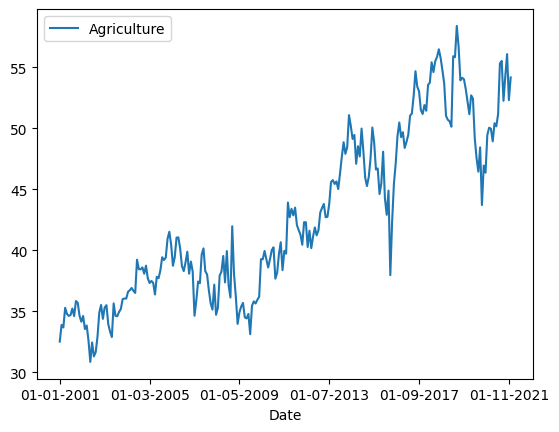

In [11]:
Agriculture_Vauxhall.plot()

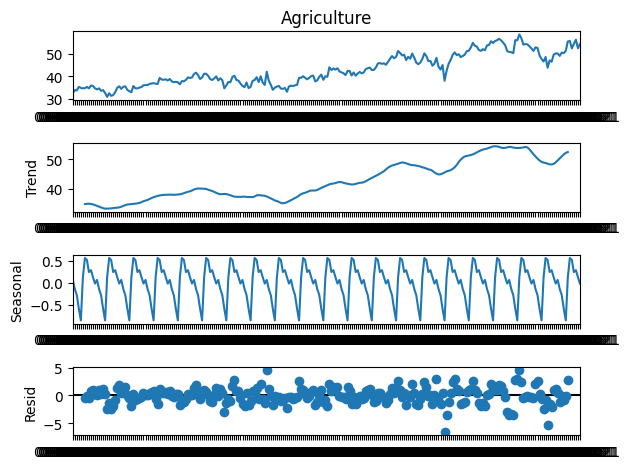

In [12]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(Agriculture_Vauxhall['Agriculture'],
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

### Dicky-Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(Agriculture_Vauxhall['Agriculture'])
print(test_result)

(-1.390508166986644, 0.5868180682840939, 1, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, 902.834330571939)


In [14]:
#Ho null hypostheis : It is non stationary
#H1 Alternate hypoyhesis : It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [15]:
adfuller_test(Agriculture_Vauxhall['Agriculture'])

ADF Test Statistic : -1.390508166986644
p-value : 0.5868180682840939
#Lags Used : 1
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### so data is not stationary we need to make it stationary

In [16]:
Agriculture_Vauxhall['Agriculture First Difference'] = Agriculture_Vauxhall['Agriculture'] - Agriculture_Vauxhall['Agriculture'].shift(1)

In [17]:
Agriculture_Vauxhall.head()

,Agriculture,Agriculture First Difference
Date,,
01-01-2001,32.521903,NaN
01-02-2001,33.898051,1.376148
01-03-2001,33.680808,-0.217243
01-04-2001,35.297448,1.616640
01-05-2001,34.795092,-0.502356


In [18]:
adfuller_test(Agriculture_Vauxhall['Agriculture First Difference'].dropna())

ADF Test Statistic : -9.62395985110668
p-value : 1.6799411474149703e-16
#Lags Used : 3
Number of Observations Used : 247
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot: xlabel='Date'>

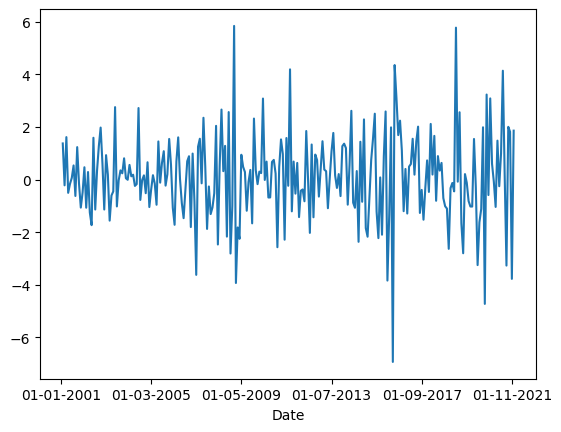

In [19]:
Agriculture_Vauxhall['Agriculture First Difference'].plot()

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


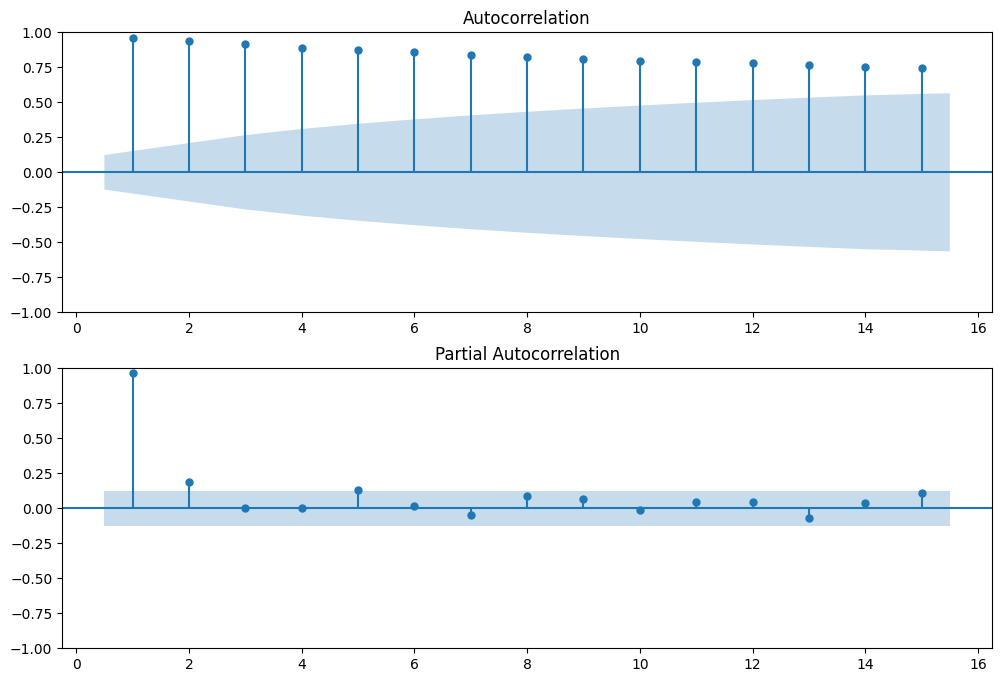

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf( Agriculture_Vauxhall['Agriculture'],zero=False,lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf( Agriculture_Vauxhall['Agriculture'],zero= False,lags=15,ax=ax2)


### ARIMA Model

In [22]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(5):
# Loop over q values from 0-2
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(Agriculture_Vauxhall['Agriculture'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

In [23]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
6   1  1   961.720637   975.838353
23  4  3   961.888728   993.653589
9   1  4   961.936885   986.642888
11  2  1   962.402658   980.049803
10  2  0   962.608699   976.726415
7   1  2   963.333714   980.980859
24  4  4   963.394260   998.688551
15  3  0   963.542358   981.189503
14  2  4   963.890867   992.126299
12  2  2   963.934602   985.111176
22  4  2   964.050338   992.285771
16  3  1   964.831397   986.007971
8   1  3   965.226823   986.403398
17  3  2   965.370744   990.076747
18  3  3   965.374402   993.609835
20  4  0   965.447418   986.623992
19  3  4   965.848355   997.613216
13  2  3   965.985432   990.691436
21  4  1   966.797120   991.503124
5   1  0   968.977457   979.565745
4   0  4  1141.055192  1162.231767
3   0  3  1192.608186  1210.255331
2   0  2  1296.993626  1311.111343
1   0  1  1434.738082  1445.326369
0   0  0  1695.050413  1702.109271
    p  q          AIC          BIC
6   1  1   961.720637   975.838353
10  2  0   962.60869

#### Here we can clearly see that value of p and q should be equal to 1, but according to graph it should be more than 1 
#### So, we are taking value of p=4 and q =3 and from dicky fuller test d=1 

In [24]:
Agriculture_Vauxhall.head()

,Agriculture,Agriculture First Difference
Date,,
01-01-2001,32.521903,NaN
01-02-2001,33.898051,1.376148
01-03-2001,33.680808,-0.217243
01-04-2001,35.297448,1.616640
01-05-2001,34.795092,-0.502356


In [25]:
model = sm.tsa.ARIMA(Agriculture_Vauxhall['Agriculture'], order=(4, 1, 3))
# Fit the model
results_ARIMAX = model.fit()

# Print model fit summary
print(results_ARIMAX.summary())

C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Agriculture   No. Observations:                  252
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -468.326
Date:                Wed, 03 Apr 2024   AIC                            952.653
Time:                        12:34:25   BIC                            980.856
Sample:                             0   HQIC                           964.002
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1673      0.107      1.571      0.116      -0.041       0.376
ar.L2         -0.4553      0.082     -5.586      0.000      -0.615      -0.296
ar.L3          0.6933      0.107      6.489      0.0

C:\Users\Dell\anaconda3\envs\DAB200\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Use testing data as of last six months

In [26]:
Agriculture_Vauxhall.tail(10)

,Agriculture,Agriculture First Difference
Date,,
01-03-2021,50.422885,1.482804
01-04-2021,50.172014,-0.250872
01-05-2021,51.175610,1.003597
01-06-2021,55.317519,4.141909
01-07-2021,55.533914,0.216395
01-08-2021,52.264987,-3.268927
01-09-2021,54.272637,2.007650
01-10-2021,56.094665,1.822028
01-11-2021,52.319947,-3.774718


In [27]:
from datetime import datetime, timedelta


train_dataset_end=datetime(2021,6,1)
test_dataset_end=datetime(2021,12,1)
train_dataset_end_str = train_dataset_end.strftime('%Y-%m-%d')
test_dataset_end_str = test_dataset_end.strftime('%Y-%m-%d')

# Slicing the DataFrame based on the dates
train_data = Agriculture_Vauxhall[:train_dataset_end_str]
test_data = Agriculture_Vauxhall[(train_dataset_end + timedelta(days=1)).strftime('%Y-%m-%d'):test_dataset_end_str]

# Displaying the sliced DataFrames
print("Train Data:")
print(train_data)
print("\nTest Data:")
print(test_data)

KeyError: '2021-06-01'

In [ ]:
Agriculture_Vauxhall.tail(6)

In [ ]:
Agriculture_Vauxhall.tail()

In [ ]:
test_data

In [ ]:
model = sm.tsa.ARIMA(train_data['Agriculture'], order=(4, 1, 3))
results = model.fit()

In [ ]:
print(results.forecast(len(test_data['Agriculture'])))

In [ ]:
print(results.forecast(6))

In [ ]:
predictions = results.forecast(len(test_data['Agriculture']))

predictions = pd.Series(predictions, index=test_data.index)
print(predictions)
residuals = test_data['Agriculture'] - predictions


plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
Agriculture_Vauxhall.head()

In [ ]:
Agriculture_Vauxhall.tail()

In [ ]:
start_date = datetime(2001, 1, 1)
end_date = datetime(2021, 12, 1)

plt.figure(figsize=(10, 4))

plt.plot(Agriculture_Vauxhall.index, Agriculture_Vauxhall['Agriculture'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Agriculture per year and Prediction of Last Six months', fontsize=20)
plt.ylabel('Agriculture', fontsize=16)

# Convert Timestamp objects to strings
for year in range(start_date.year, end_date.year):
    plt.axvline(str(year) + '-01-01', color='k', linestyle='--', alpha=0.2)

plt.show()


In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data['Agriculture'])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


#### Prediction of next 6 months

In [ ]:
forecast= results_ARIMAX.forecast(steps=6)

In [ ]:
print("Forecasted Sales for the next 6 months:", forecast)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(Agriculture_Vauxhall.index, Agriculture_Vauxhall['Agriculture'], label='Historical Sales')

# Plot predicted sales
forecast_index = pd.date_range(start=Agriculture_Vauxhall.index[-1], periods=7, freq='M')[1:]
print(forecast_index)
#plt.plot(forecast_index, forecast, label='Predicted Agriculture', color='red')

plt.title('Historical vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Agriculture')
plt.legend()
plt.show()

In [ ]:
plt.plot(forecast_index, forecast, label='Predicted Agriculture', color='red')

In [ ]:
plt.plot(forecast)

In [ ]:
plt.plot(forecast_index)

In [ ]:
forecast_index = pd.date_range(start=Agriculture_Vauxhall.index[-1], periods=7, freq='M')[1:]

In [ ]:
print(forecast_index)